In [2]:
#import smopy
%matplotlib inline
import json
import os
import glob
import folium
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from shapely import wkt
from shapely import affinity
from tqdm.notebook import tqdm
import shapely
import osmnx as ox

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
BASE_PATH = os.path.join(os.getenv('HOME'), 'workspace/Hackerton') # project folder
DATA_PATH = os.path.join(BASE_PATH, 'RSI_OP_NIA_AIHUB') # data folder
SAMPLE_GEOJSON_PATH = os.path.join(DATA_PATH, 'buildings/training/label/BLD00001_PS3_K3A_NIA0276.json') # sample geojson file path
MERGED_PATH = os.path.join(DATA_PATH, 'merged') # summary dir folder
MERGED_PATH = os.path.join(DATA_PATH, 'merged')

In [4]:
area_path = os.path.join(MERGED_PATH, 'Site.csv')
df = pd.read_csv(area_path, encoding='utf-8')
df.head(5)

,image_id,coordinates
0,BLD09459_PS3_K3A_NIA0386,"POLYGON((-117.5802189538 33.8220932145, -117.5..."
1,BLD03308_PS3_K3A_NIA0376,"POLYGON((10.7713793216 52.4989244922, 10.77967..."
2,BLD07002_PS3_K3A_NIA0382,"POLYGON((-117.8606648806 33.8943077818, -117.8..."
3,BLD06236_PS3_K3A_NIA0381,"POLYGON((-117.8703695761 33.8003080145, -117.8..."
4,BLD07313_PS3_K3A_NIA0382,"POLYGON((-117.9574299656 33.8326421794, -117.9..."


In [5]:
print(df.shape)

(2208, 2)


In [6]:
df['coordinates'] = gpd.GeoSeries.from_wkt(df['coordinates'])

In [7]:
gdf = gpd.GeoDataFrame(df, geometry='coordinates')

In [8]:
minx, miny, maxx, maxy = gdf['coordinates'].bounds['minx'], gdf['coordinates'].bounds['miny'], gdf['coordinates'].bounds['maxx'],gdf['coordinates'].bounds['maxy']

In [9]:
minx[0], miny[0], maxx[0], maxy[0]

(-117.5802532626, 33.8220932145, -117.5741332396, 33.827201041)

In [10]:
#map = smopy.Map((miny[0],minx[0],maxy[0],maxx[0]), z=17)

In [11]:
#map.show_ipython()

In [12]:
m = folium.Map(location=[45.523, -122.675], width=1024, height=1024)
m.fit_bounds([[miny[0],minx[0]],[maxy[0],maxx[0]]])
m.save('test.html')

# Get Tile and convert it to tiff
ref)

## Needed function

In [12]:

from math import log, tan, radians, cos, pi, floor, degrees, atan, sinh


def sec(x):
    return(1/cos(x))


def latlon_to_xyz(lat, lon, z):
    tile_count = pow(2, z)
    x = (lon + 180) / 360
    y = (1 - log(tan(radians(lat)) + sec(radians(lat))) / pi) / 2
    return(tile_count*x, tile_count*y)


def bbox_to_xyz(lon_min, lon_max, lat_min, lat_max, z):
    x_min, y_max = latlon_to_xyz(lat_min, lon_min, z)
    x_max, y_min = latlon_to_xyz(lat_max, lon_max, z)
    return(floor(x_min), floor(x_max),
           floor(y_min), floor(y_max))


def mercatorToLat(mercatorY):
    return(degrees(atan(sinh(mercatorY))))


def y_to_lat_edges(y, z):
    tile_count = pow(2, z)
    unit = 1 / tile_count
    relative_y1 = y * unit
    relative_y2 = relative_y1 + unit
    lat1 = mercatorToLat(pi * (1 - 2 * relative_y1))
    lat2 = mercatorToLat(pi * (1 - 2 * relative_y2))
    return(lat1, lat2)


def x_to_lon_edges(x, z):
    tile_count = pow(2, z)
    unit = 360 / tile_count
    lon1 = -180 + x * unit
    lon2 = lon1 + unit
    return(lon1, lon2)


def tile_edges(x, y, z):
    lat1, lat2 = y_to_lat_edges(y, z)
    lon1, lon2 = x_to_lon_edges(x, z)
    return[lon1, lat1, lon2, lat2]

In [13]:
import rasterio
from rasterio.plot import show
import os

image_path = "/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00007_PS4_K3A_NIA0276.tif"
src = rasterio.open(image_path)
left, bottom, right, top = src.bounds
print(left, bottom, right, top)

348520.80134696 3323841.2769356696 349084.00134696 3324404.47693567


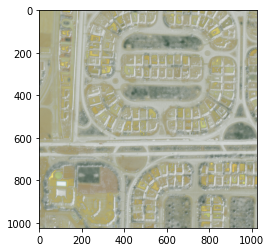

<AxesSubplot:>

In [14]:
from rasterio.plot import show
#show(src)
norm_src = rasterio.plot.adjust_band(src.read())

show(norm_src)

In [16]:
t_x_min, t_y_min, t_x_max, t_y_max= 340072.8013469600118697,3317646.0769356698729098,340636.0013469600235112,3318209.2769356700591743

In [17]:
from rasterio.warp import transform
from rasterio.crs import CRS
new_crs = CRS.from_epsg(4326)   # standard WGS84 coordinates
prev_crs = CRS.from_epsg(32636)
conv_coo = transform(prev_crs, new_crs, 
                    xs=[t_x_min, t_x_max], ys=[t_y_min, t_y_max])
print(conv_coo)
print(src.crs)



([31.342285286916667, 31.348036961007566], [29.979283687949476, 29.98443758451307])
EPSG:32636


In [18]:
highway_tags = {'highway' : ["motorway","trunk","primary","secondary","tertiary","residential","motorway_link","trunk_link","primary_link","secondary_link","tertiary_link","service","track","raceway"]}

In [19]:
print(highway_tags)

{'highway': ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'residential', 'motorway_link', 'trunk_link', 'primary_link', 'secondary_link', 'tertiary_link', 'service', 'track', 'raceway']}


In [20]:
def read_tif(image_path) :
    src = rasterio.open(image_path)
    left, bottom, right, top = src.bounds
    norm_src = rasterio.plot.adjust_band(src.read())
    conv_coo = change_crs([left, bottom, right, top], int(str(src.crs).split(":")[1]))
    bound_area = shapely.geometry.box(conv_coo[0],conv_coo[1],conv_coo[2],conv_coo[3])
    return norm_src, bound_area

In [21]:
from rasterio.warp import transform
from rasterio.crs import CRS
def change_crs(coords, prev_crs) :
    '''
    coords : left, top, right, bottom 순으로 coords가 들어온다. 
    prev_crs : coords의 원래 좌표계
    return : 좌표계가 변환된 coords들이 list에 담겨 반환된다. 
    '''
    prev_crs = CRS.from_epsg(prev_crs)
    new_crs = CRS.from_epsg(4326)
    conv_coo = transform(prev_crs, new_crs, xs = [coords[0],coords[2]], ys = [coords[1], coords[3]])
    return [conv_coo[0][0],conv_coo[1][0],conv_coo[0][1],conv_coo[1][1]]

참고한 사이트 :
1. 영역만 출력하기
https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/
2. clip geopandas
https://geopandas.org/gallery/plot_clip.html

In [22]:
'''
1. 쿼리 날릴 종류
2. 쿼리 날릴 영역
3. 쿼리 결과 리턴
'''
def send_query(target_area, tag_list) :
    '''
    target_area : 탐색할 영역이 polygon으로 들어온다.  
    tag_list : osmnx을 이용해서 추출할 osm vector type을 dictionary로 받는다. 
    '''
    # query 대상 지역 가장자리
    target_area_boundary = target_area.exterior
    #target_area.set_crs(4326, allow_override=True)
    # query 결과
    query_result = ox.geometries.geometries_from_polygon(target_area, tags=tag_list)
    #query_result.plot()
    # geopandas 연산 사용을 위해 query 대상 
    #print("query_result")
    target_area_boundary_gdf = gpd.GeoDataFrame(geometry=[target_area.exterior])
    target_area_boundary_gdf = target_area_boundary_gdf.set_crs('epsg:4326', allow_override=True)
    target_area_gdf = gpd.GeoDataFrame(geometry=[target_area])
    target_area_gdf = target_area_gdf.set_crs('epsg:4326', allow_override=True)
    query_result_clip = gpd.clip(query_result,target_area_gdf)
    #print(query_result_clip)
    query_result_clip = query_result_clip[~query_result_clip.is_empty]
    query_result_without_point = query_result_clip[query_result_clip['geometry'].apply(lambda x : False if x.geom_type == 'Point' or x.geom_type == 'MultiPoint' else True)]
    
    #print(query_result_without_point['geometry'])
    #final_result = gpd.overlay(query_result_without_point,target_area_boundary_gdf, how='union',keep_geom_type=False)
    #final_result = final_result.set_crs('epsg:4326', allow_override=True)
    return query_result_without_point, target_area_boundary_gdf

In [23]:
image_root_path = "/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB"
target_path = "/roads/training/raw/"
osm_path = "/roads/training/raw/osm/"
target_image_list = os.listdir(image_root_path + target_path)
target_image_list = [x for x in target_image_list if x.split('.')[-1] == 'tif']
print(target_image_list[:5])

['BLD03409_PS4_K3A_NIA0376.tif', 'BLD00403_PS4_K3A_NIA0276.tif', 'BLD04783_PS4_K3A_NIA0378.tif', 'BLD02727_PS4_K3A_NIA0375.tif', 'BLD01578_PS4_K3A_NIA0373.tif']


In [24]:
building_tags = {'building' : True,
                'landuse': ['commercial', 'construction', 'education', 'industrial', 'residential', 'retail']}
extra_tags = {'natural' : ['water','wood','tree','sand'],
              'water':'lake', 
              'waterway':['river','stream'], 
              'landuse':['forest','grass']}

## test query

In [25]:
image_path = "/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD00007_PS4_K3A_NIA0276.tif"
norm_src, bound_area = read_tif(image_path)
result, bound_area_gdf = send_query(bound_area,building_tags)

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


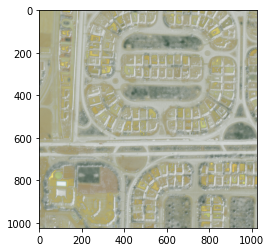

<AxesSubplot:>

In [24]:
show(norm_src)

<AxesSubplot:>

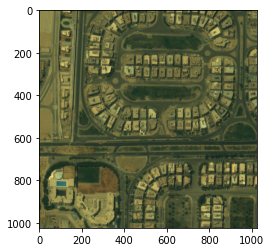

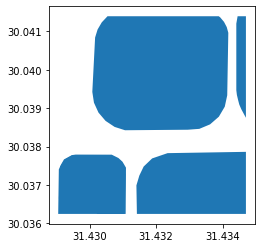

In [26]:
#type(norm_src[:-1])
#plt.imshow(norm_src[:-1])
#result.plot()
restack_norm_src = np.stack(norm_src[:-1],axis=2)
plt.imshow(restack_norm_src)
result.plot()
#restack_norm_src.shape
#norm_1 = norm_src.read(1)
#norm_2 = norm_src.read(2)
#norm_3 = norm_src.read(3) 


In [25]:
building_area_list = []
road_area_list = []
building_query_result_list = []
road_query_result_list = []


original_tif_list = []


In [26]:
from tqdm import tqdm
#target_list = ["BLD00237_PS4_K3A_NIA0276","BLD00595_PS4_K3A_NIA0277","BLD00599_PS4_K3A_NIA0277"]
#format_name = '.tif'
target_area_list= []
extra_query_result_list = []
count = 0
for f in tqdm(target_image_list) :
    full_path = image_root_path + target_path + f
    print(f)
    example_tif, bounds = read_tif(full_path)
    original_tif_list.append(example_tif)
    
    #show(example_tif)
    #result1, target_area1 = send_query(bounds, building_tags)
    #result.plot()
    
    #result2, target_area2 = send_query(bounds, highway_tags)
    #print(target_area)
    #target_area.plot()
    #result.plot()
    #building_area_list.append(target_area1)
    #road_area_list.append(target_area2)
    #road_query_result_list.append(result1)
    #building_query_result_list.append(result2)
    
    result, target_area = send_query(bounds, extra_tags)
    extra_query_result_list.append(result)
    target_area_list.append(target_area)
    
    if count == 100 :
        break
    
    count += 1

  0%|          | 0/1144 [00:00<?, ?it/s]

BLD03409_PS4_K3A_NIA0376.tif


  0%|          | 1/1144 [00:00<12:37,  1.51it/s]

BLD00403_PS4_K3A_NIA0276.tif


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
  0%|          | 2/1144 [00:01<09:20,  2.04it/s]

BLD04783_PS4_K3A_NIA0378.tif


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
  0%|          | 3/1144 [00:01<08:22,  2.27it/s]

BLD02727_PS4_K3A_NIA0375.tif


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
  0%|          | 4/1144 [00:01<07:47,  2.44it/s]

BLD01578_PS4_K3A_NIA0373.tif


  0%|          | 4/1144 [00:02<10:27,  1.82it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
#target_list = ["BLD00237_PS4_K3A_NIA0276","BLD00595_PS4_K3A_NIA0277","BLD00599_PS4_K3A_NIA0277"]
#format_name = '.tif'
building_area_list = []
road_area_list = []
building_query_result_list = []
road_query_result_list = []

target_area_list= []
#extra_query_result_list = []
original_tif_list = []
count = 0

for f in tqdm(target_image_list) :
    full_path = image_root_path + target_path + f
    print(f)
    example_tif, bounds = read_tif(full_path)
    original_tif_list.append(example_tif)
    
    #show(example_tif)
    #result1, target_area1 = send_query(bounds, building_tags)
    #result.plot()
    
    result2, target_area2 = send_query(bounds, highway_tags)
    #print(target_area)
    #target_area.plot()
    #result.plot()
    #building_area_list.append(target_area1)
    target_area_list.append(target_area2)
    road_query_result_list.append(result2)
    #building_query_result_list.append(result2)
    
    #result, target_area = send_query(bounds, extra_tags)
    #extra_query_result_list.append(result)
    #target_area_list.append(target_area)
    count += 1
    if count == 100 :
        break

In [ ]:
print(len(extra_query_result_list))

In [ ]:
extra_count = 0
extra_not_null = []
for i in extra_query_result_list : 
    if not i.empty :
        #print(extra_count)
        extra_not_null.append(extra_count)
        print(i)
        extra_count += 1

road_count = 0
for i in road_query_result_list : 
    if not i.empty :
        road_count += 0

In [ ]:
#road/train/raw/
print(extra_count/100)
print(extra_not_null)
print(road_count/100)
for i in extra_not_null :
    full_path = image_root_path + target_path + target_image_list[i]
    print(full_path)

In [ ]:
extra_example = extra_query_result_list[0]
target_area_example = target_area_list[0]


###### import gc
count = 0
for i in extra_query_result_list :
    if not i.empty : 
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.contourf(arr)
        plt.savefig(fn)

        plt.close(fig)

        gc.collect()
        i.plot()
    else: 
        print(count)
    count += 1

In [ ]:
#plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
#my_dpi = 96
target_image_path = target_image_list[2]
print(image_root_path + target_path + target_image_path)

im_tif, bound = read_tif(image_root_path + target_path + target_image_path)
show(im_tif)




In [ ]:
extra_query_result_list[2]

In [ ]:
my_dpi = 96
#fig, ax = plt.subplots(figsize = (1024/my_dpi,1024/my_dpi), dpi = my_dpi)
fig, ax = plt.subplots(figsize = (10,10))
ex_example = extra_query_result_list[2]
print(ex_example)
ex_target_example = target_area_list[2]

xlim = ([ex_example.total_bounds[0],  ex_example.total_bounds[2]])
ylim = ([ex_example.total_bounds[1],  ex_example.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ex_example.plot(alpha = .5, ax = ax)

#ax.set(title='Natural Earth Global Roads \n Zoomed into the United States')
ax.set_axis_off()
plt.show()

In [ ]:
fig, ax = plt.subplots()
#fig.dpi


# Save Image

In [27]:
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [1024/300, 1024/300]
ROAD_PATH = os.path.join(DATA_PATH, "roads/training/raw")
target_image_list = os.listdir(ROAD_PATH)
target_image_list = [x for x in target_image_list if x.split('.')[-1] == 'tif']
save_image_path = os.path.join(DATA_PATH,"roads/training/osm")
count = 0
#my_dpi = 226
my_dpi = 200
no_network_roads_gdf=[]
no_network_roads_name=[]
plt.rcParams['axes.facecolor'] = 'w'
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
total_geo_gdf = gpd.GeoDataFrame()
#total_geo_gdf.set_axis(['geometry','filename'], axis=1)
total_geo_gdf['geometry'] = ''
total_geo_gdf['filename'] = ''
count = 284
#print(target_image_list[48])
#for f in tqdm(target_image_list[327+239+284:]) :
for f in tqdm(target_image_list) :
    #if count < 418 :
    #    count += 1
    #    continue
    #f = target_image_list[48]
    file_path = os.path.join(ROAD_PATH,f)
    file_name = f.split('.')[0]
    #print(file_name)
    new_file_name = file_name.replace('PS4','PS3')
    save_file_path = os.path.join(save_image_path,new_file_name+".png")
    src = rasterio.open(file_path)
   
    left, bottom, right, top  = transform_bounds(
        src.crs,
        {'init': 'EPSG:4326'},
        src.bounds.left,
        src.bounds.bottom,
        src.bounds.right,
        src.bounds.top)
    #left, bottom, right, top
    north, south, east, west = top, bottom, right, left
    tags = {'building' : True}
    point = ((north+south)/2, (east+west)/2)
    gdf = ox.geometries_from_bbox(north, south, east, west, tags=highway_tags)
    #fig, ax = plt.subplots(figsize = (1024/my_dpi,1024/my_dpi))
    try : 
        fig, ax = ox.plot_figure_ground(
            point=point,
            save=True, 
            show=False, 
            close=True,
            bbox=(north, south, east, west),
            edge_color='g',
            network_type="all",
            default_width=2,
            street_widths=None,
            bgcolor='white',
            filepath=save_file_path,
            
            dpi = my_dpi,
            dist=281.6, # (.55 * 1024)/2
            )
        #print(file_name)
    except :
        fig, ax = ox.plot_footprints(
            gdf, filepath=save_file_path,
            color='g',
            save=True, show=False, close=True,
            bbox=(top, bottom, right, left),
            bgcolor='white',
            #figsize = (1024/my_dpi,1024/my_dpi),
            #figsize = (1024*px,1024*px),
            dpi = my_dpi
        )
        #print(file_name)
    #_idx = 'BLD03437_PS3_K3A_NIA0376'
    #print(save_image_path)
    gdf['filename'] = new_file_name
    a = cv2.imread(save_file_path)
    a = cv2.resize(a, dsize=(1024, 1024), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_file_path, a)
    #print(gdf[['geometry','filename']])'
   # print(total_geo_gdf.columns.tolist())
    #print(gdf.columns.tolist())
    #total_geo_gdf.concat(pd.DataFrame(gdf[['geometry','filename']],columns=['geometry','filename']),ignore_index = True)
    total_geo_gdf = total_geo_gdf.append(pd.DataFrame(gdf[['geometry','filename']]))
    if count % 30 == 0 :
        total_geo_gdf.to_file(f"roads_train_{count}.geojson", driver='GeoJSON',index=False)
    count += 1
total_geo_gdf.to_file("roads_train_{count}.geojson", driver='GeoJSON',index=False)
    #print(total_geo_gdf)


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/matplotlib_inline/config.py:61: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):
  2%|▏         | 7/294 [00:39<29:22,  6.14s/it]/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
  9%|▉         | 26/294 [03:08<41:09,  9.21s/it]/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site

## OSM 라벨 생성한거 training, validation, test 세트로 나누기

In [44]:
import shutil
label_list_files = []
label_list_path = os.path.join(os.getenv("HOME"),"workspace/Hackerton/RSI_OP_NIA_AIHUB/list")
label_list_files = os.listdir(label_list_path)
label_list_files_B = [x for x in label_list_files if x.startswith("R_")]
for f in label_list_files_B :
    p = os.path.join(label_list_path, f)
    list_file = open(p, 'r')
    lines = list_file.readlines()
    cat = ""
    if 'train' in f :
        cat1 = 'training'
        cat2 = 'training'
    elif 'test' in f :
        cat1 = 'validation'
        cat2 = 'test'
    else :
        cat1 = 'training'
        cat2 = 'validation'
    
    # file 목록 가져와서
    # 원래 위치와 옮길 주소 만들기
    # 파일 한꺼번에 옮기기
    origin_path = []
    target_path = []
    
    origin_dir = os.path.join(DATA_PATH,"roads/"+cat1+"/osm")
    target_dir = os.path.join(DATA_PATH, "roads/new_label/"+cat2+"/osm")
    
    for l in lines :
        l = l.rstrip('\n')
        op = os.path.join(origin_dir,l)
        tp = os.path.join(target_dir,l)
        origin_path.append(op)
        target_path.append(tp)
        shutil.copy(op, tp)

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/list/R_test_list.txt' mode='r' encoding='UTF-8'>
  
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/list/R_train_list.txt' mode='r' encoding='UTF-8'>
  
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/list/R_val_list.txt' mode='r' encoding='UTF-8'>
  


In [28]:
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import cv2
ROAD_PATH = os.path.join(DATA_PATH, "roads/training/raw")
target_image_list = os.listdir(ROAD_PATH)
target_image_list = [x for x in target_image_list if x.split('.')[-1] == 'tif']
save_image_path = os.path.join(DATA_PATH,"roads/training/osm")
#f = target_image_list[47]
f = 'BLD00243_PS4_K3A_NIA0276.tif'
my_dpi = 200
file_path = os.path.join(ROAD_PATH,f)
print(target_image_list.index(f))
file_name = f.split('.')[0]
#print(file_name)
print(file_name)
new_file_name = file_name.replace('PS4','PS3')
save_file_path = os.path.join(save_image_path,new_file_name+".png")
src = rasterio.open(file_path)
left, bottom, right, top  = transform_bounds(
    src.crs,
    {'init': 'EPSG:4326'},
    src.bounds.left,
    src.bounds.bottom,
    src.bounds.right,
    src.bounds.top)
#left, bottom, right, top
north, south, east, west = top, bottom, right, left
tags = {'building' : True}
point = ((north+south)/2, (east+west)/2)
gdf = ox.geometries_from_bbox(north, south, east, west, tags=highway_tags)
#fig, ax = plt.subplots(figsize = (1024/my_dpi,1024/my_dpi))

total_geo_gdf = gpd.GeoDataFrame()
try : 
    fig, ax = ox.plot_figure_ground(
        point=point,
            save=True, 
            show=False, 
            close=True,
            bbox=(north, south, east, west),
            edge_color='g',
            network_type="all",
            default_width=2,
            street_widths=None,
            bgcolor='white',
            filepath=save_file_path,
            
            dpi = my_dpi,
            dist=281.6, # (.55 * 1024)/2
        )
    #fig.savefig(save_file_path, dpi=300)
    #print(file_name)
except :
    #no_network_roads_gdf.append(gdf)
    #no_network_roads_name.append(file_name)
    #print(gdf)

    fig, ax = ox.plot_footprints(
        gdf, filepath=save_file_path,
        color='g',
        save=False, show=False, close=True,
        bbox=(top, bottom, right, left),
        bgcolor='white',
        #figsize = (1024/my_dpi,1024/my_dpi),
        #figsize = (1024*px,1024*px),
        dpi = my_dpi,
    )
    #fig.savefig(save_file_path, dpi=300)
a = cv2.imread(save_file_path)
a = cv2.resize(a, dsize=(1024, 1024), interpolation=cv2.INTER_AREA)
cv2.imwrite(save_file_path, a)


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


617
BLD00243_PS4_K3A_NIA0276


True

In [1]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [1024/200, 1024/200]
ROAD_PATH = os.path.join(DATA_PATH, "roads/train/raw")
target_image_list = os.listdir(ROAD_PATH)
target_image_list = [x for x in target_image_list if x.split('.')[-1] == 'tif']
save_image_path = os.path.join(DATA_PATH,"roads/train/osm")
count = 0
#my_dpi = 226
my_dpi = 200
no_network_roads_gdf_2=[]
no_network_roads_name_2=[]
plt.rcParams['axes.facecolor'] = 'w'
total_geo_gdf = gpd.GeoDataFrame()
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
for f in tqdm(target_image_list) :
    
    #if count < 418 :
    #    count += 1
    #    continue
    file_path = os.path.join(ROAD_PATH,f)
    norm_src, bounds = read_tif(file_path)
    #show(norm_src)
    file_name = f.split('.')[0]
    #print(file_name)
    new_file_name = file_name.replace('PS4','PS3')
    save_file_path = os.path.join(save_image_path,new_file_name+".png")
    src = rasterio.open(file_path)
    left, bottom, right, top  = transform_bounds(
        src.crs,
        {'init': 'EPSG:4326'},
        src.bounds.left,
        src.bounds.bottom,
        src.bounds.right,
        src.bounds.top)
    #left, bottom, right, top
    north, south, east, west = top, bottom, right, left
    tags = {'building' : True}
    point = ((north+south)/2, (east+west)/2)
    gdf = ox.geometries_from_bbox(north, south, east, west, tags=highway_tags)
    print(file_name)
    #fig, ax = plt.subplots(figsize = (1024/my_dpi,1024/my_dpi))
    try : 
        fig, ax = ox.plot_figure_ground(
            point=point,
            save=True, 
            show=False, 
            close=True,
            bbox=(north, south, east, west),
            edge_color='g',
            network_type="all",
            default_width=2,
            street_widths=None,
            bgcolor='white',
            filepath=save_file_path,
            
            dpi = my_dpi,
            dist=281.6, # (.55 * 1024)/2
            )
    except :
        no_network_roads_gdf_2.append(gdf)
        no_network_roads_name_2.append(file_name)
        #print(gdf)
        
        fig, ax = ox.plot_footprints(
            gdf, filepath=save_file_path,
            color='g',
            save=True, show=False, close=True,
            bbox=(top, bottom, right, left),
            bgcolor='white',
            #figsize = (1024*px,1024*px),
            dpi = my_dpi,
        )
        #fig.savefig(save_file_path, dpi=200)
        
    
    #print(file_name)
    #_idx = 'BLD03437_PS3_K3A_NIA0376'
    #print(save_image_path)
    gdf['filename'] = 'file_name'
    
    total_geo_gdf.append(gdf[['geometry','filename']])
    a = cv2.imread(save_file_path)
    a = cv2.resize(a, dsize=(1024, 1024), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_file_path, a)
    
total_geo_gdf.to_file("roads_val.geojson", driver='GeoJSON')

NameError: name 'plt' is not defined

In [16]:
ROAD_PATH = os.path.join(DATA_PATH, "roads/validation/raw")
print(ROAD_PATH)

/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/roads/validation/raw


In [33]:
from PIL import Image

root = os.path.join(DATA_PATH,'roads/training/osm')
im = Image.open(root+"/BLD00001_PS4_K3A_NIA0276.png").convert('RGBA')

im.size  # (364, 471)
im.getbbox()  # (64, 89, 278, 267)
print(im.getbbox())
im2 = im.crop(im.getbbox())
print(im2)
im2.size  # (214, 178)

im2 = im2.resize((1024,1024),Image.ANTIALIAS)
print(im2.size)
im2.save(root+'/foo.png')

#background = Image.new('RGBA', png.size, (255,255,255))

#alpha_composite = Image.alpha_composite(background, png)
#alpha_composite.save(root+'/foo.png', 'PNG', quality=100)

(138, 123, 911, 896)
<PIL.Image.Image image mode=RGBA size=773x773 at 0x7F34B1A13ED0>
(1024, 1024)


In [50]:
# remove transparent edges from images 
from PIL import Image
root = os.path.join(DATA_PATH,'roads/training/osm')
target_image_list = os.listdir(root)
for i in tqdm(target_image_list) :
    image_path = os.path.join(root, i)
    
    im = Image.open(image_path)
    im2 = im.crop(im.getbbox())
    if im.getbbox() == im2.getbbox() : 
        continue        
    im2 = im2.resize((1024,1024),Image.ANTIALIAS)
    im2.save(image_path)
    
    

  0%|          | 0/1145 [00:00<?, ?it/s]

In [51]:
# remove transparent edges from images 
from PIL import Image
root = os.path.join(DATA_PATH,'roads/validation/osm')
target_image_list = os.listdir(root)
for i in tqdm(target_image_list) :
    image_path = os.path.join(root, i)
    
    im = Image.open(image_path)
    im2 = im.crop(im.getbbox())
    if im.getbbox() == im2.getbbox() : 
        continue        
    im2 = im2.resize((1024,1024),Image.ANTIALIAS)
    im2.save(image_path)

  0%|          | 0/127 [00:00<?, ?it/s]

In [87]:
my_dpi = 96
print(no_network_roads_gdf)
for i in range(len(no_network_roads_gdf)) :
    gdf = no_network_roads_gdf[i]
    name = no_network_roads_name[i]
    save_file_path = os.path.join(save_image_path,name+".png")
    fig, ax = ox.plot_footprints(
            gdf, ax=ax, filepath=save_file_path,
            dpi=200,
            color='g',
            save=True, show=False, close=True,
            bbox=(top, bottom, right, left),
            bgcolor='#000000',
            figsize = (1024/my_dpi,1024/my_dpi)
        )
    print(name)
    break
    

[]


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Run til this block

In [66]:
ex_example

natural  \
element_type osmid               
way          28397477      NaN   
             446834416   water   
             446834418   water   
             446834420   water   
             446834422   water   

                                                                 geometry  \
element_type osmid                                                          
way          28397477   POLYGON ((10.85308 52.48263, 10.85334 52.48266...   
             446834416  POLYGON ((10.85232 52.48340, 10.85228 52.48332...   
             446834418  POLYGON ((10.85284 52.48332, 10.85278 52.48323...   
             446834420  POLYGON ((10.85274 52.48318, 10.85268 52.48308...   
             446834422  POLYGON ((10.85222 52.48330, 10.85219 52.48324...   

                                                                    nodes  \
element_type osmid                                                          
way          28397477   [311935225, 311935226, 311935227, 311935228, 3...   
             446834416  [4440584471, 4440584468, 4440584466, 444058447...   
             446834418  [4440584469, 4440584464, 4440584459, 444058446...   
             446834420  [4440584461, 4440584457, 4440584456, 444058445...   
             446834422  [4440584467, 4440584462, 4440584460, 444058446...   

                       landuse leaf_type  
element_type osmid                        
way          28397477   forest     mixed  
             446834416     NaN       NaN  
             446834418     NaN       NaN  
             446834420     NaN       NaN  
             446834422     NaN       NaN

In [ ]:
print(len(target_image_list))
print(len(building_query_result_list)) 

In [29]:
#example_tif, bounds = read_tif(image_path)
#result = send_query(bounds, highway_tags)
#result.plot()

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


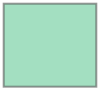

In [30]:
road_boundary = shapely.geometry.box(conv_coo[0][0],conv_coo[1][0],conv_coo[0][1],conv_coo[1][1])
road_boundary


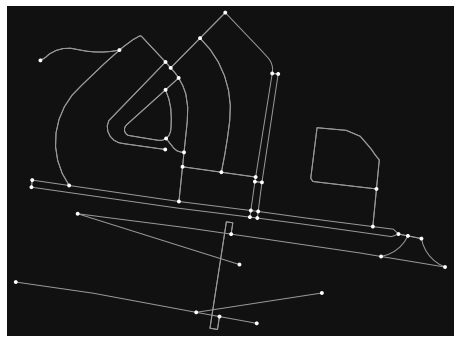

'\nBLD00237_PS3_K3A_NIA0276\n\nBLD00595_PS3_K3A_NIA0277\n\nBLD00599_PS3_K3A_NIA0277\n'

In [31]:
road_gdf = ox.graph_from_polygon(road_boundary)
ox.plot_graph(road_gdf)
'''
BLD00237_PS3_K3A_NIA0276

BLD00595_PS3_K3A_NIA0277

BLD00599_PS3_K3A_NIA0277
'''

In [32]:
from rasterio.warp import transform
from rasterio.crs import CRS

new_crs = CRS.from_epsg(4326)   # standard WGS84 coordinates
new_coo = transform(src.crs, new_crs, 
                    xs=[left, right], ys=[top, bottom])
new_coo

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([31.42886345971509, 31.434783000883346],
 [30.041325511285002, 30.036314419681137])

In [23]:
#map = smopy.Map((new_coo[1][0],new_coo[0][0],new_coo[0][1],new_coo[1][1]), z=17)
#map.show_ipython()

In [33]:
import math
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [34]:
min_num = deg2num(new_coo[1][0], new_coo[0][0], 18)
max_num = deg2num(new_coo[1][1], new_coo[0][1], 18)
print(min_num, max_num)
print((max_num[0]-min_num[0]) * (max_num[1] - min_num[1]))

(153957, 108119) (153962, 108123)
20


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import utm

import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [36]:
gpd.__version__, ox.__version__

('0.9.0', '1.1.1')

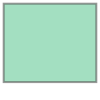

In [37]:
# shapely.geometry.Polygon
import shapely
from shapely.geometry import Polygon
from shapely.geometry import box

# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
boundary = shapely.geometry.box(new_coo[0][0],new_coo[1][0],new_coo[0][1],new_coo[1][1])
boundary


In [80]:
print(boundary)

POLYGON ((31.43478300088335 30.041325511285, 31.43478300088335 30.03631441968114, 31.42886345971509 30.03631441968114, 31.42886345971509 30.041325511285, 31.43478300088335 30.041325511285))


In [29]:
import rtree
import pygeos
rtree.__version__, pygeos.__version__

('0.9.7', '0.10')

In [30]:
gpd.options.use_pygeos = False
import pygeos

In [31]:
import geopandas as gpd
from shapely.geometry import Polygon


polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                        Polygon([(2,2), (4,2), (4,4), (2,4)])])

polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                        Polygon([(3,3), (5,3), (5,5), (3,5)])])

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

res_union = gpd.overlay(df1, df2, how='union')

In [86]:
import pygeos
import rtree
buildings_gdf = ox.geometries.geometries_from_polygon(boundary, tags={'highway' : 'residential', 'highway' : 'service'})

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
import osgeo.gdal

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
buildings_gdf.shape

(7, 4)

In [97]:
for i in buildings_gdf['geometry'].values :
    print(i)

LINESTRING (31.4221936 30.0512743, 31.4222943 30.0513978, 31.4224568 30.0514811, 31.4226472 30.0514579, 31.4247386 30.0513857, 31.4267392 30.0511392, 31.42723 30.0509122, 31.4278108 30.0504453, 31.4280843 30.0499004, 31.428148 30.0492713, 31.428118 30.0480357, 31.4281172 30.047998, 31.4281085 30.0472861, 31.4281091 30.0472229, 31.4281405 30.0468617, 31.4282716 30.0465471, 31.4283767 30.0463942, 31.4291033 30.0453374, 31.4294255 30.0447991, 31.429508 30.0443353, 31.4294892 30.0437969, 31.42944 30.0428859, 31.4294357 30.0428063, 31.4292995 30.0402846, 31.4293012 30.0402512, 31.4293163 30.0399611, 31.4293625 30.0382154)
LINESTRING (31.4271087 30.0386341, 31.4274264 30.0386261, 31.427956 30.0387043, 31.4282613 30.0388445, 31.4285167 30.0390036, 31.4287971 30.0392787, 31.4289341 30.0394512, 31.4290182 30.0395942, 31.4290681 30.0397371, 31.4291096 30.0398388, 31.4291285 30.0399579, 31.4291258 30.0400303, 31.4290934 30.0401027, 31.4290557 30.0401354, 31.4289504 30.0401588, 31.4287886 30.04015

<AxesSubplot:>

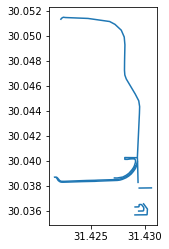

In [93]:
buildings_gdf.plot()

In [90]:
buildings_gdf.crs

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

ValueError: Axis limits cannot be NaN or Inf

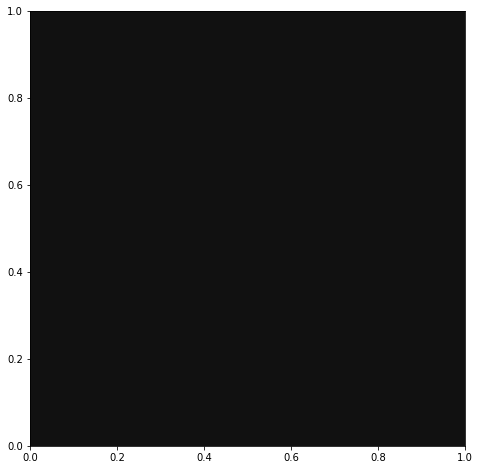

In [92]:
from IPython.display import Image
gdf_proj = ox.project_gdf(buildings_gdf)
extension = "png"
size = 1024
img_folder = "/home/aiffel-dj15/workspace/osm"
fp = f"{img_folder}/piedmont_bldgs.{extension}"
fig, ax = ox.plot_footprints(gdf_proj, filepath=fp, dpi=400, save=True, show=False)
Image(fp, height=size, width=size)

In [132]:
buildings_gdf.bounds

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


minx       miny       maxx       maxy
element_type osmid                                                
way          363536185  31.422194  30.038215  31.429508  30.051481
             391300792  31.427109  30.038626  31.429301  30.040263
             394736862  31.429398  30.037822  31.430665  30.037837
             394736863  31.421753  30.038290  31.429205  30.039656
             394736864  31.421585  30.038361  31.429316  30.039961
             394736866  31.429005  30.035675  31.430226  30.036607
             887458475  31.429018  30.035982  31.429893  30.036507

In [ ]:
# what do I need to do? 
"""
1. get a tif file from folder
2. get the area that tif file is placed on 
3. get the roads list with osmnx with the area information
4. crop the roads with the area information
5. sum the area and the cropped roads in single geopandas
6. save it with 1024x1024 image file after coloring background and road with different color
""" 

In [ ]:
#norm_img, boundary = read_tiff(image_path)
#print(boundary)
#show(norm_img)
target_area = wkt.loads('POLYGON ((-117.9181600654000022 33.9876473819999987, -117.9120630452000000 33.9876927315999993, -117.9121173120999941 33.9927715500000005, -117.9182146950000032 33.9927261917000010, -117.9181600654000022 33.9876473819999987))')
target_area.boundary 
result = send_query(boundary, {'building' : True})


In [289]:
print(boundary.exterior)
buildings_gdf.bounds
buildings_geometry = gpd.GeoDataFrame(geometry=buildings_gdf['geometry'])
buildings_geometry.plot()
poly_gdf1 = gpd.GeoDataFrame(geometry=[boundary])
poly_exterior = gpd.GeoDataFrame(geometry=[boundary.exterior])
buildings_geometry.reset_index(drop=True)
print(buildings_geometry)
#print(boundary.exterior)
#intersection = buildings_geometry.intersection(poly_gdf1,align=True)
intersection = gpd.overlay(poly_exterior, buildings_geometry, how='union')
print(intersection)
intersection.plot()
ne_roads_clip = gpd.clip(buildings_geometry, poly_gdf1)

# Ignore missing/empty geometries
ne_roads_clip = ne_roads_clip[~ne_roads_clip.is_empty]
#print(ne_roads_clip)
ne_roads_clip = gpd.overlay(poly_exterior, ne_roads_clip, how='union')
ne_roads_clip.plot()
#print()
#print(poly_gdf1)

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'list' object has no attribute 'exterior'

POLYGON ((0.0003065469178586236 28.51019974253718, 0.0003065931345881704 28.51019974253716, 0.0003065931345648562 28.51019968742463, 0.0003065469178353129 28.51019968742465, 0.0003065469178586236 28.51019974253718))


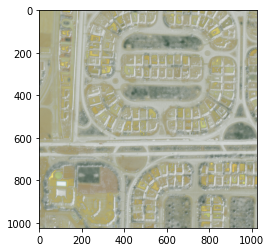

<AxesSubplot:>

In [238]:
norm_img, boundary = read_tiff(image_path)
print(boundary)
show(norm_img)

348520.80134696 3323841.2769356696 349084.00134696 3324404.47693567
<class 'rasterio.coords.BoundingBox'>
BoundingBox(left=348520.80134696, bottom=3323841.2769356696, right=349084.00134696, top=3324404.47693567)
[31.42886345971509, 30.041325511285002, 31.434783000883346, 30.036314419681137]


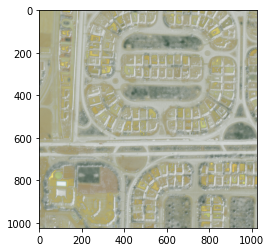

<AxesSubplot:>

In [248]:
norm_img, boundary = read_tiff(image_path)
print(boundary)
show(norm_img)

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


                                                                    nodes  \
element_type osmid                                                          
way          100004595  [1156251589, 1156252446, 1156254023, 798092406...   
             100004645  [1156252334, 1156253155, 1156250826, 115625230...   
             100004654  [1156253712, 1156254049, 1156250685, 115625326...   
             100004669  [1156249617, 1156253614, 1156251582, 115625093...   
             100004735  [1156251693, 1156253815, 1156249692, 115625042...   
...                                                                   ...   
relation     6937838    [[[4654193948, 4654197892, 4654192625, 4654194...   
             6937839    [[[4654191927, 4654194246, 4654198690, 4654192...   
             6937842    [[[4654194609, 4654199345, 4654193176, 4654196...   
             6937843    [[[4654191195, 4654193502, 4654197141, 4654192...   
             6937845    [[[4654198737, 4654192971, 4654195588, 4654191...   

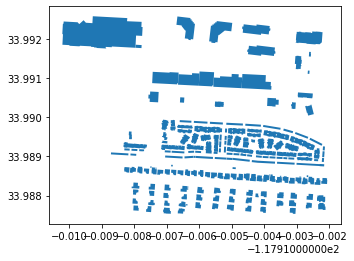

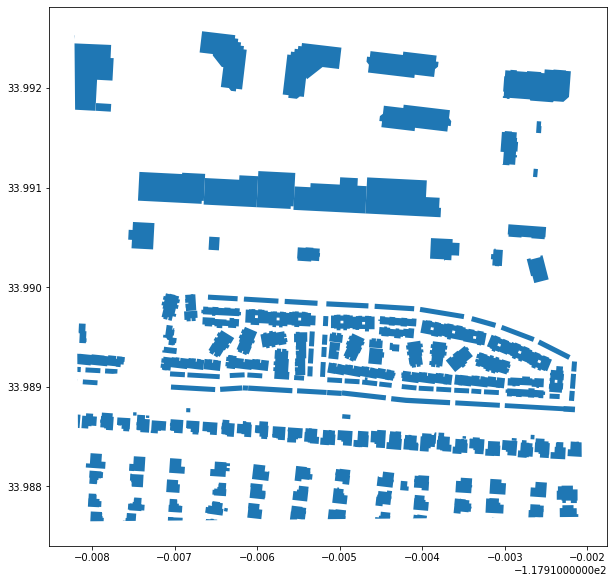

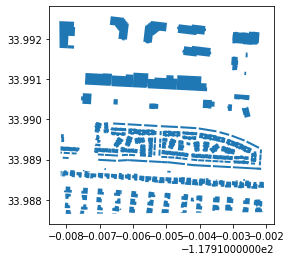

In [228]:
from shapely import wkt
target_area = wkt.loads('POLYGON ((-117.9181600654000022 33.9876473819999987, -117.9120630452000000 33.9876927315999993, -117.9121173120999941 33.9927715500000005, -117.9182146950000032 33.9927261917000010, -117.9181600654000022 33.9876473819999987))')
#print(list(target_area.boundary.coords))
#coords_box = shapely.geometry.box(minx, miny, maxx, maxy)
#coords_box
#print(coords)
#new_crs = CRS.from_epsg(4326)   # standard WGS84 coordinates
#new_coo = transform(src.crs, new_crs, 
#                    xs=[left, right], ys=[top, bottom])
#target_buildings = ox.geometries.geometries_from_polygon(target_area, tags={'building' : True})
#print(target_buildings)
result = send_query(target_area, {'building' : True})
result.plot()
print(result)

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

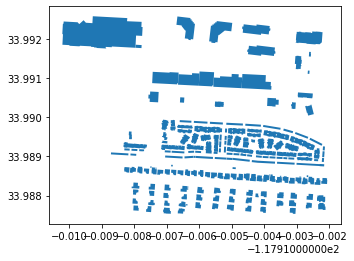

In [130]:
target_buildings.plot()

In [136]:
target_buildings['geometry']

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


element_type  osmid    
way           100004595    POLYGON ((-117.91389 33.99049, -117.91363 33.9...
              100004645    POLYGON ((-117.91467 33.99110, -117.91395 33.9...
              100004654    POLYGON ((-117.91663 33.99110, -117.91622 33.9...
              100004669    POLYGON ((-117.91563 33.99234, -117.91559 33.9...
              100004735    POLYGON ((-117.91450 33.99161, -117.91449 33.9...
                                                 ...                        
relation      6937838      POLYGON ((-117.91246 33.98898, -117.91247 33.9...
              6937839      POLYGON ((-117.91491 33.98958, -117.91491 33.9...
              6937842      POLYGON ((-117.91316 33.98952, -117.91312 33.9...
              6937843      POLYGON ((-117.91325 33.98942, -117.91329 33.9...
              6937845      POLYGON ((-117.91614 33.98977, -117.91610 33.9...
Name: geometry, Length: 191, dtype: geometry

In [138]:
print(target_area.exterior)

LINEARRING (-117.9181600654 33.987647382, -117.9120630452 33.9876927316, -117.9121173121 33.99277155, -117.918214695 33.9927261917, -117.9181600654 33.987647382)


/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

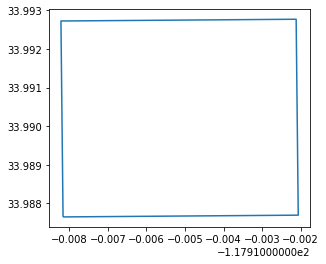

In [140]:
target_area_exterior = gpd.GeoDataFrame(geometry=[target_area.exterior])
target_area_exterior.plot()

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  


element_type  osmid    
way           100004595    POLYGON ((-117.91389 33.99049, -117.91363 33.9...
              100004645    POLYGON ((-117.91467 33.99110, -117.91395 33.9...
              100004654    POLYGON ((-117.91663 33.99110, -117.91622 33.9...
              100004669    POLYGON ((-117.91563 33.99234, -117.91559 33.9...
              100004735    POLYGON ((-117.91450 33.99161, -117.91449 33.9...
                                                 ...                        
relation      6937838      POLYGON ((-117.91246 33.98898, -117.91247 33.9...
              6937839      POLYGON ((-117.91491 33.98958, -117.91491 33.9...
              6937842      POLYGON ((-117.91316 33.98952, -117.91312 33.9...
              6937843      POLYGON ((-117.91325 33.98942, -117.91329 33.9...
              6937845      POLYGON ((-117.91614 33.98977, -117.91610 33.9...
Name: geometry, Length: 191, dtype: geometry


<AxesSubplot:>

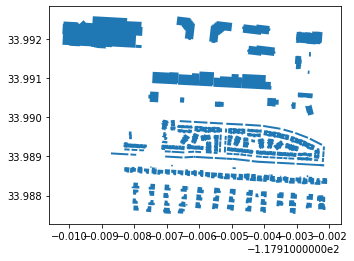

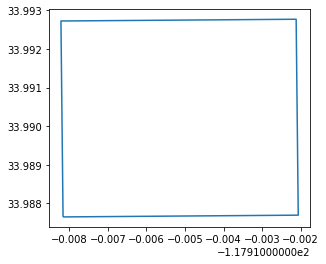

<Figure size 1080x1080 with 0 Axes>

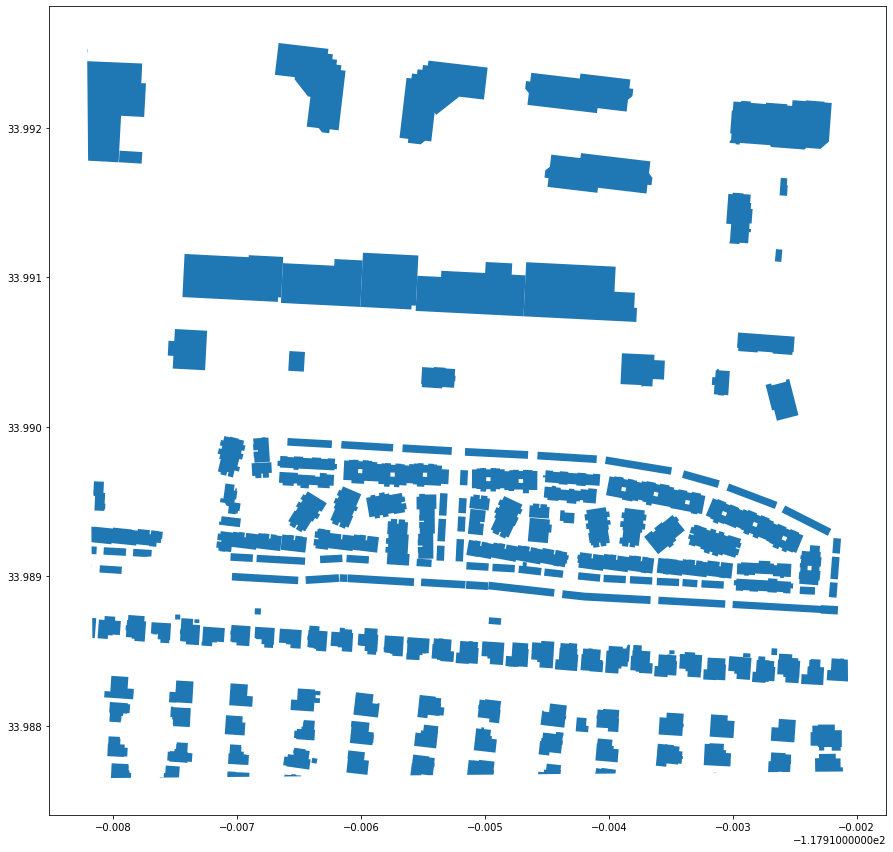

In [155]:
target_area_gdf = gpd.GeoDataFrame(geometry=[target_area])
target_buildings_geometry = gpd.GeoDataFrame(geometry=target_buildings['geometry'])
target_area_exterior = gpd.GeoDataFrame(geometry=[target_area.exterior])
#print(boundary.exterior)
#intersection = buildings_geometry.intersection(poly_gdf1,align=True)
intersection = gpd.overlay(target_buildings_geometry, target_area_exterior, how='union')
#print(intersection)
intersection.plot()
target_area_exterior.plot()
ne_roads_clip = gpd.clip(target_buildings,target_area)

# Ignore missing/empty geometries
ne_roads_clip = ne_roads_clip[~ne_roads_clip.is_empty]
print(ne_roads_clip['geometry'])
#print(ne_roads_clip)
#ne_roads_clip = gpd.overlay(target_area_exterior, ne_roads_clip, how='union')
plt.figure(figsize=(15,15))
ne_roads_clip.plot(figsize=(15, 15))
#print()
#print(poly_gdf1)

In [157]:
target_roads = ox.geometries.geometries_from_polygon(target_area, tags={'highway' : 'residential', 'highway' : 'service'})

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

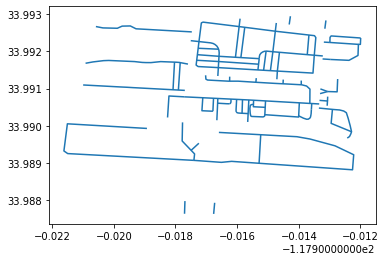

In [158]:
target_roads.plot()

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  
/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  


element_type  osmid    
way           100004626    LINESTRING (-117.91592 33.99274, -117.91593 33...
              100004647    LINESTRING (-117.91528 33.99181, -117.91528 33...
              100004740    LINESTRING (-117.91313 33.99276, -117.91315 33...
              100004925    LINESTRING (-117.91759 33.99166, -117.91785 33...
              100004946    LINESTRING (-117.91430 33.99276, -117.91431 33...
                                                 ...                        
              930884956    LINESTRING (-117.91660 33.99173, -117.91530 33...
              930884957    LINESTRING (-117.91588 33.99183, -117.91575 33...
              930884958    LINESTRING (-117.91506 33.99201, -117.91514 33...
              930884959    LINESTRING (-117.91484 33.99199, -117.91492 33...
              930884960    LINESTRING (-117.91367 33.99244, -117.91372 33...
Name: geometry, Length: 68, dtype: geometry


<AxesSubplot:>

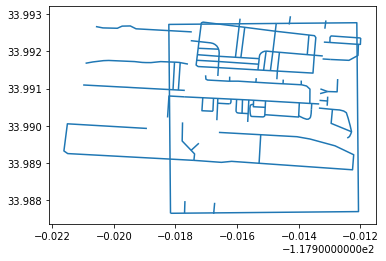

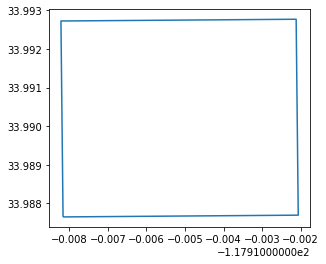

<Figure size 1080x1080 with 0 Axes>

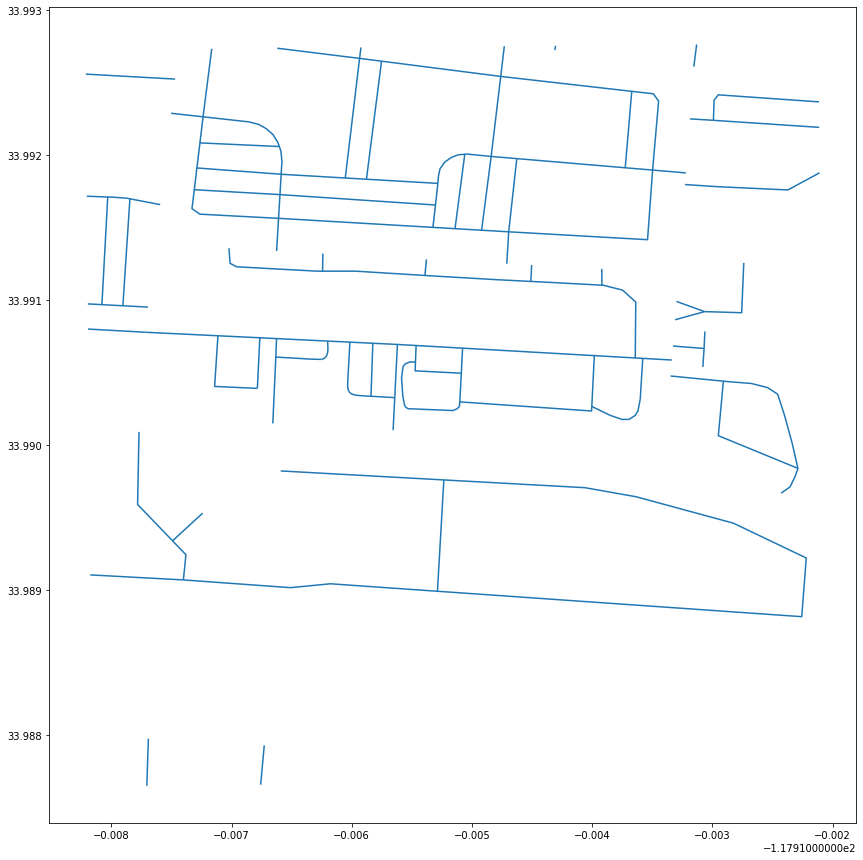

In [160]:
target_area_gdf = gpd.GeoDataFrame(geometry=[target_area])
target_roads_geometry = gpd.GeoDataFrame(geometry=target_roads['geometry'])
target_area_exterior = gpd.GeoDataFrame(geometry=[target_area.exterior])
#print(boundary.exterior)
#intersection = buildings_geometry.intersection(poly_gdf1,align=True)
intersection = gpd.overlay(target_roads_geometry, target_area_exterior, how='union')
#print(intersection)
intersection.plot()
target_area_exterior.plot()
ne_roads_clip = gpd.clip(target_roads_geometry,target_area)

# Ignore missing/empty geometries
ne_roads_clip = ne_roads_clip[~ne_roads_clip.is_empty]
print(ne_roads_clip['geometry'])
#print(ne_roads_clip)
#ne_roads_clip = gpd.overlay(target_area_exterior, ne_roads_clip, how='union')
plt.figure(figsize=(15,15))
ne_roads_clip.plot(figsize=(15, 15))
#print()
#print(poly_gdf1)

In [63]:
polygon_result = buildings_gdf[buildings_gdf['geometry'].apply(lambda x : True if x.geom_type == 'Polygon' else False)]

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
polygon_result

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


barrier  \
element_type osmid               
way          10873198      NaN   
             24724766      NaN   
             24748791      NaN   
             24783991      NaN   
             24886453      NaN   
...                        ...   
             721206650     NaN   
             867276409     NaN   
             934506244     NaN   
             939423560     NaN   
             939423561     NaN   

                                                                 geometry  \
element_type osmid                                                          
way          10873198   POLYGON ((31.23303 30.04753, 31.23303 30.04723...   
             24724766   POLYGON ((31.40032 30.11171, 31.40023 30.11170...   
             24748791   POLYGON ((31.26316 30.04836, 31.26277 30.04752...   
             24783991   POLYGON ((31.32490 30.09362, 31.32523 30.09384...   
             24886453   POLYGON ((31.33039 30.08684, 31.33015 30.08671...   
...                                                                   ...   
             721206650  POLYGON ((30.30192 31.34333, 30.30216 31.34357...   
             867276409  POLYGON ((30.06477 31.31826, 30.06487 31.31830...   
             934506244  POLYGON ((30.19071 31.12746, 30.19180 31.12717...   
             939423560  POLYGON ((30.13837 31.26981, 30.13840 31.26977...   
             939423561  POLYGON ((30.13879 31.26980, 30.13882 31.26976...   

                        highway                 note source addr:street  \
element_type osmid                                                        
way          10873198       NaN  tag name --> arabic    NaN         NaN   
             24724766       NaN                  NaN    NaN         NaN   
             24748791       NaN                  NaN    NaN         NaN   
             24783991       NaN                  NaN    NaN         NaN   
             24886453       NaN                  NaN    NaN         NaN   
...                         ...                  ...    ...         ...   
             721206650  service                  NaN    NaN         NaN   
             867276409      NaN                  NaN    NaN         NaN   
             934506244      NaN                  NaN    NaN         NaN   
             939423560      NaN                  NaN    NaN         NaN   
             939423561      NaN                  NaN    NaN         NaN   

                                 amenity    building  \
element_type osmid                                     
way          10873198                NaN      public   
             24724766                NaN         yes   
             24748791   place_of_worship         yes   
             24783991   place_of_worship      church   
             24886453   place_of_worship         yes   
...                                  ...         ...   
             721206650               NaN         NaN   
             867276409               NaN         yes   
             934506244               NaN  industrial   
             939423560               NaN         yes   
             939423561               NaN         yes   

                                                  name          name:ar  ...  \
element_type osmid                                                       ...   
way          10873198   Museum of Egyptian Antiquities    المتحف المصري  ...   
             24724766                              NaN              NaN  ...   
             24748791                      مسجد الحسين      مسجد الحسين  ...   
             24783991                   كنيسة البازليك   كنيسة البازليك  ...   
             24886453                  قصر بارون أمبان  قصر بارون أمبان  ...   
...                                                ...              ...  ...   
             721206650                             NaN              NaN  ...   
             867276409                             NaN              NaN  ...   
             934506244                             NaN              NaN  

/home/aiffel-dj15/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

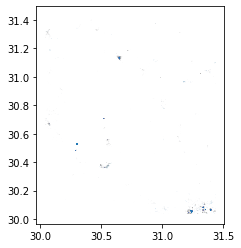

In [65]:
polygon_result.plot()

In [ ]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [23]:
import math
import urllib.request
import os
import glob
import subprocess
import shutil
from osgeo import gdal

#---------- CONFIGURATION -----------#
tile_server = "https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token="+"pk.eyJ1IjoiaHllbWlqZW9uZyIsImEiOiJja3AycGxtcTkxbHN2MnBxcWkxeW9kcWx6In0.ryRBUd6ViJzgXTyqOXkBrw"
workspace_dir = os.path.join(os.getenv("HOME"), 'workspace') 
temp_dir = os.path.join(workspace_dir, 'osm/temp')
output_dir = os.path.join(workspace_dir, 'osm/output')
zoom = 19
lon_min = min(new_coo[0])
lon_max = max(new_coo[0])
lat_min = min(new_coo[1])
lat_max = max(new_coo[1])
#-----------------------------------#


def download_tile(x, y, z, tile_server):
    url = tile_server.replace(
        "{x}", str(x)).replace(
        "{y}", str(y)).replace(
        "{z}", str(z))
    path = f'{temp_dir}/{x}_{y}_{z}.png'
    urllib.request.urlretrieve(url, path)
    return(path)


def merge_tiles(input_pattern, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path]

    for name in glob.glob(input_pattern):
        merge_command.append(name)

    subprocess.call(merge_command)


def georeference_raster_tile(x, y, z, path):
    bounds = tile_edges(x, y, z)
    filename, extension = os.path.splitext(path)
    gdal.Translate(filename + '.tif',
                   path,
                   outputSRS='EPSG:4326',
                   outputBounds=bounds)


x_min, x_max, y_min, y_max = bbox_to_xyz(
    lon_min, lon_max, lat_min, lat_max, zoom)

print(f"Downloading {(x_max - x_min + 1) * (y_max - y_min + 1)} tiles")

for x in range(x_min, x_max + 1):
    for y in range(y_min, y_max + 1):
        print(f"{x},{y}")
        png_path = download_tile(x, y, zoom, tile_server)
        georeference_raster_tile(x, y, zoom, png_path)

print("Download complete")

print("Merging tiles")
merge_tiles(temp_dir + '/*.tif', output_dir + '/merged.tif')
print("Merge complete")

shutil.rmtree(temp_dir)
os.makedirs(temp_dir)

307915,216238
307915,216239
307915,216240
307915,216241
307915,216242
307915,216243
307915,216244
307915,216245
307915,216246
307915,216247
307916,216238
307916,216239
307916,216240
307916,216241
307916,216242
307916,216243
307916,216244
307916,216245
307916,216246
307916,216247
307917,216238
307917,216239
307917,216240
307917,216241
307917,216242
307917,216243
307917,216244
307917,216245
307917,216246
307917,216247
307918,216238
307918,216239
307918,216240
307918,216241
307918,216242
307918,216243
307918,216244
307918,216245
307918,216246
307918,216247
307919,216238
307919,216239
307919,216240
307919,216241
307919,216242
307919,216243
307919,216244
307919,216245
307919,216246
307919,216247
307920,216238
307920,216239
307920,216240
307920,216241
307920,216242
307920,216243
307920,216244
307920,216245
307920,216246
307920,216247
307921,216238
307921,216239
307921,216240
307921,216241
307921,216242
307921,216243
307921,216244
307921,216245
307921,216246
307921,216247
307922,216238
307922